In [1]:
## Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [11]:
## Getting the data from Yahoo Finance
#pip install yfinance
import yfinance as yf
ticker = 'WU'
df = yf.download(ticker)

[*********************100%***********************]  1 of 1 completed


In [13]:
df

Price,Close,High,Low,Open,Volume
Ticker,WU,WU,WU,WU,WU
Date,,,,,
2006-10-02,10.786124,10.960798,10.464069,10.480445,7111800
2006-10-03,10.917130,10.938965,10.715163,10.857086,11416000
2006-10-04,10.797041,10.944421,10.644201,10.917129,10722800
2006-10-05,10.720620,10.889836,10.693328,10.889836,8782400
2006-10-06,10.682414,10.797044,10.545950,10.753376,6282100
...,...,...,...,...,...
2025-01-13,10.350000,10.390000,10.190000,10.200000,3324500
2025-01-14,10.460000,10.490000,10.330000,10.400000,3399000


In [14]:
if 'Close' not in df.columns:
    raise ValueError("Dataset must contain a 'Close' column.")

# Sort data by date (if not already sorted)
df = df.sort_values('Date')


In [15]:
# Normalize the 'Close' prices using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close']].values)

# Parameters
sequence_length = 60

In [16]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

# Create input sequences and labels
X, y = create_sequences(scaled_data, sequence_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the input data to 3D (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [18]:
# Define the LSTM model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - loss: 0.0328 - val_loss: 0.0014
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0019 - val_loss: 9.7030e-04
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0017 - val_loss: 8.6516e-04
Epoch 6/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0013 - val_loss: 9.9558e-04
Epoch 7/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0015 - val_loss: 7.6706e-04
Epoch 8/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0011 - val_loss: 7.8172e-04
Epoch 9/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0012 - val_loss: 7.1080e-04
Epoch 10/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0010 - val_loss: 6.5847e-04
Epoch 11/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0010 - val_loss: 6.5990e-04
Epoch 12

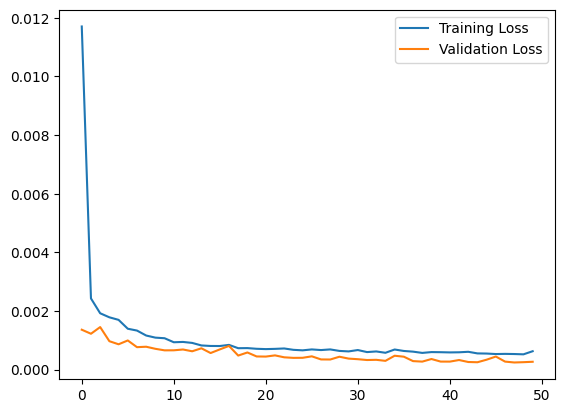

In [19]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Plot training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


<Sequential name=sequential_1, built=True>

In [20]:
# Evaluate on the test set
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.5116e-04
Test Loss: 0.00026919852825812995


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


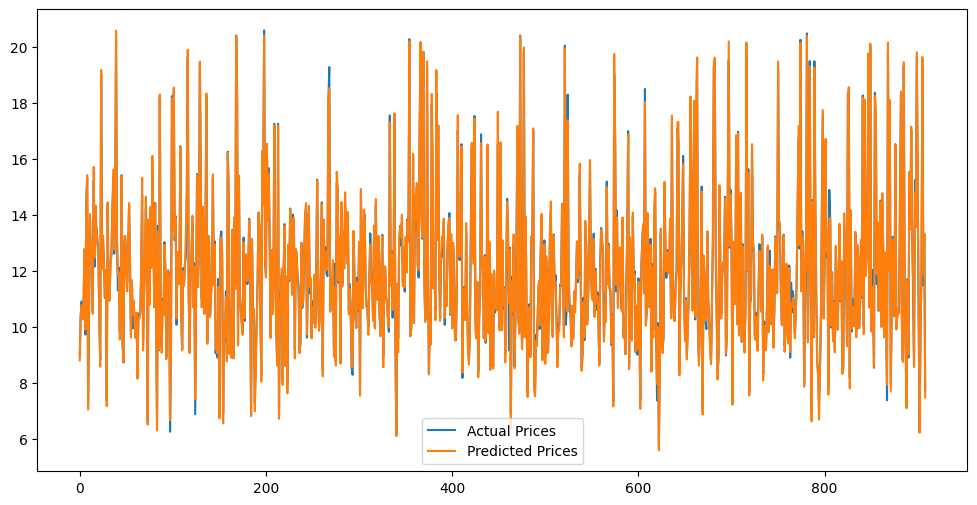

In [21]:
# Predict on the test data
predictions = model.predict(X_test)

# Reverse the scaling for predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Prices')
plt.plot(predictions, label='Predicted Prices')
plt.legend()
plt.show()


In [23]:
# Save the trained model
model.save('lstm_stock_price_model.h5')


In [24]:
# Prepare the input data for the prediction
last_sequence = scaled_data[-sequence_length:]  # Get the last sequence_length data points
last_sequence = last_sequence.reshape((1, sequence_length, 1))  # Reshape to 3D

# Predict the price
predicted_scaled_price = model.predict(last_sequence)

# Reverse the scaling to get the actual price
predicted_price = scaler.inverse_transform(predicted_scaled_price)
print(f"Predicted price for 01-20-2025: {predicted_price[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted price for 01-20-2025: 10.412075996398926


## Predict for future days

In [27]:
def predict_future_prices(model, last_sequence, n_days, scaler):
    """
    Predict future stock prices for n_days.
    
    Parameters:
    - model: Trained LSTM model
    - last_sequence: The last `sequence_length` data points (scaled)
    - n_days: Number of future days to predict
    - scaler: The MinMaxScaler used for scaling the data
    
    Returns:
    - predictions: A list of predicted stock prices (unscaled)
    """
    predictions = []
    input_sequence = last_sequence

    for _ in range(n_days):
        # Reshape input_sequence to 3D (samples, timesteps, features)
        input_sequence_reshaped = input_sequence.reshape((1, input_sequence.shape[0], 1))
        
        # Predict the next value
        next_prediction = model.predict(input_sequence_reshaped, verbose=0)[0][0]
        
        # Append prediction to the result (unscale it)
        predictions.append(scaler.inverse_transform([[next_prediction]])[0][0])
        
        # Update the input_sequence (append the prediction and drop the oldest value)
        input_sequence = np.append(input_sequence[1:], [next_prediction], axis=0)

    return predictions


In [28]:
# Get the last sequence from the scaled data
last_sequence = scaled_data[-sequence_length:].flatten()


In [35]:
n_days = 10  # Number of future days to predict
future_predictions = predict_future_prices(model, last_sequence, n_days, scaler)

# Display the results
print(f"Predicted prices for the next {n_days} days:")
for i, price in enumerate(future_predictions, start=1):
    print(f"Day {i}: {price:.2f}")


Predicted prices for the next 10 days:
Day 1: 10.41
Day 2: 10.36
Day 3: 10.32
Day 4: 10.28
Day 5: 10.24
Day 6: 10.20
Day 7: 10.16
Day 8: 10.13
Day 9: 10.09
Day 10: 10.05


## Visualizing the prediction



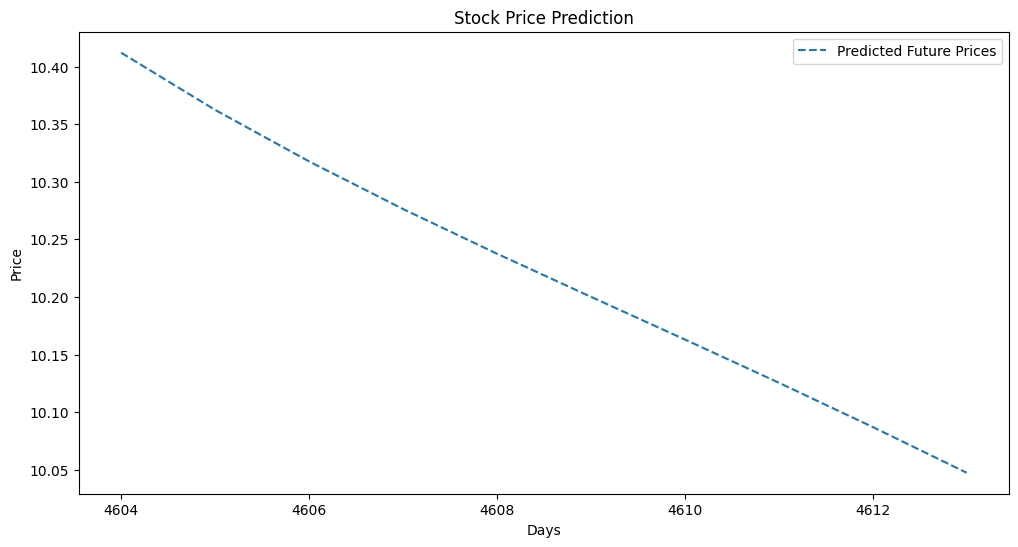

In [36]:
# Get actual historical prices (unscaled)
historical_prices = scaler.inverse_transform(scaled_data)

# Create a time axis
import matplotlib.pyplot as plt

total_days = len(historical_prices) + n_days
historical_days = list(range(len(historical_prices)))
future_days = list(range(len(historical_prices), total_days))

plt.figure(figsize=(12, 6))
#plt.plot(historical_days, historical_prices, label='Historical Prices')
plt.plot(future_days, future_predictions, label='Predicted Future Prices', linestyle='--')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Stock Price Prediction')
plt.show()